In [18]:
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx
import pandas as pd
import os
import geopandas as gpd
import contextily as ctx
%matplotlib inline
!pip install haversine
from haversine import haversine, Unit

In [19]:
df=pd.read_csv('alt_fuel_stations (Apr 3 2023).csv', skiprows=None, usecols=['Station Name', 'Street Address','City','ZIP','Latitude','Longitude'])

df= df.loc[df['Longitude'] < -110]  # filter out points that are out of CA

print(len(df))

sf_bay_area = ['Alameda', 'Albany', 'American Canyon', 'Antioch', 'Atherton', 'Belmont', 'Belvedere', 'Benicia', 'Berkeley', 'Brentwood', 'Brisbane', 'Burlingame', 'Calistoga', 'Campbell', 'Clayton', 'Cloverdale', 'Colma', 'Concord', 'Corte Madera', 'Cotati', 'Cupertino', 'Daly City', 'Danville', 'Dixon', 'Dublin', 'East Palo Alto', 'El Cerrito', 'Emeryville', 'Fairfax', 'Fairfield', 'Foster City', 'Fremont', 'Gilroy', 'Half Moon Bay', 'Hayward', 'Healdsburg', 'Hercules', 'Hillsborough', 'Lafayette', 'Larkspur', 'Livermore', 'Los Altos', 'Los Altos Hills', 'Los Gatos', 'Martinez', 'Menlo Park', 'Mill Valley', 'Millbrae', 'Milpitas', 'Monte Sereno', 'Moraga', 'Morgan Hill', 'Mountain View', 'Napa', 'Newark', 'Novato', 'Oakland', 'Oakley', 'Orinda', 'Pacifica', 'Palo Alto', 'Petaluma', 'Piedmont', 'Pinole', 'Pittsburg', 'Pleasant Hill', 'Pleasanton', 'Portola Valley', 'Redwood City', 'Richmond', 'Rio Vista', 'Rohnert Park', 'Ross', 'St. Helena', 'San Anselmo', 'San Bruno', 'San Carlos', 'San Francisco', 'San Jose', 'San Leandro', 'San Mateo', 'San Pablo', 'San Rafael', 'San Ramon', 'Santa Clara', 'Santa Rosa', 'Saratoga', 'Sausalito', 'Sebastopol', 'Sonoma', 'South San Francisco', 'Suisun City', 'Sunnyvale', 'Tiburon', 'Union City', 'Vacaville', 'Vallejo', 'Walnut Creek', 'Windsor', 'Woodside', 'Yountville']

print(len(sf_bay_area))

df = df[df['City'].isin(sf_bay_area)]
df


14149
101


C:\Users\Nacuoy\AppData\Local\Temp\ipykernel_20620\1921791878.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('alt_fuel_stations (Apr 3 2023).csv', skiprows=None, usecols=['Station Name', 'Street Address','City','ZIP','Latitude','Longitude'])


Station Name          Street Address  \
14                           East Bay Mini        4340 Rosewood Dr   
21              Hyatt at Fisherman's Wharf          555 N Point St   
23                            Palace Hotel     2 New Montgomery St   
24     Mark Hopkins InterContinental Hotel       999 California St   
55     City of Vacaville - Cultural Center          1000 Ulatis Dr   
...                                    ...                     ...   
14098            HGI   SUNNYVALE STATION 1      767 N Mathilda Ave   
14104             Raley's Fairfield Travis        3001 Travis Blvd   
14110          1200 California Corporation  1200 California Street   
14117      Zum Services Inc - Davidson Ave       1645 Davidson Ave   
14129               Carondelet High School          1133 Winton Dr   

                City    ZIP   Latitude   Longitude  
14        Pleasanton  94588  37.700187 -121.876172  
21     San Francisco  94133  37.806190 -122.415200  
23     San Francisco  94105  37.788810 -122.401000  
24     San Francisco  94108  37.791791 -122.411265  
55         Vacaville  95687  38.356027 -121.962800  
...              ...    ...        ...         ...  
14098      Sunnyvale  94085  37.394685 -122.029664  
14104      Fairfield  94534  38.257412 -122.065426  
14110  San Francisco  94109  37.791743 -122.414455  
14117  San Francisco  94124  37.745530 -122.392720  
14129        Concord  94518  37.933020 -122.033016  

[4321 rows x 6 columns]

In [20]:
## create a network
## node represents a charging station, link represent the a connection between charging stations if distance between two stations is less than the threshold

G = nx.Graph()

for i, row in df.iterrows():
    G.add_node(row['Street Address'], city=row['City'], zipcode=row['ZIP'], lat=row['Latitude'], lon=row['Longitude'])


for node1 in G.nodes():
    for node2 in G.nodes():
        if node1 != node2:
            dist = haversine((G.nodes[node1]['lat'], G.nodes[node1]['lon']), (G.nodes[node2]['lat'], G.nodes[node2]['lon']), unit=Unit.MILES)
            if dist < 3:  # adjust distance threshold as needed
                G.add_edge(node1, node2, distance=dist)

Size of largest component: 1367
1


C:\Users\Nacuoy\AppData\Local\Temp\ipykernel_20620\1471889635.py:11: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig('G.png', bbox_inches='tight', dpi=600)


Number of nodes: 1367
Number of edges: 46454
Average degree: 33.98244330651061
avg_degree: 67.96488661302122
Average shortest path length:  11.744444718157876
Average Clustering Coefficient <C>: 0.7848861518958574


C:\Users\Nacuoy\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


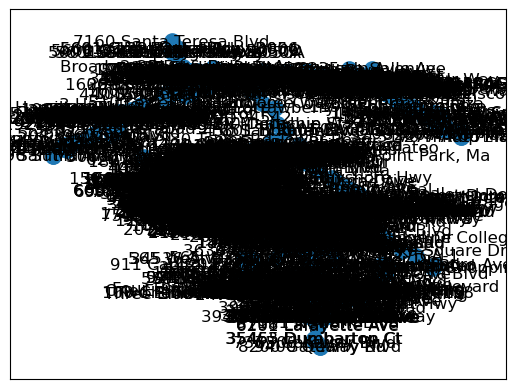

In [23]:
## filter out the biggest connected component 

Gcc = sorted(nx.connected_components(G), key=len)
largest_component = max(nx.connected_components(G), key=len)
print("Size of largest component:", len(largest_component))

print(len(Gcc))

G = G.subgraph(Gcc[-1])

print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())
print("Average degree:", G.number_of_edges()/G.number_of_nodes())
print("avg_degree:", sum(dict(G.degree()).values()) / len(G))       # which one to use for calculating average degree? 
print("Average shortest path length: ", nx.average_shortest_path_length(G))
print("Average Clustering Coefficient <C>:", nx.average_clustering(G))
# filter the DataFrame to keep only nodes in the largest component
df_largest = df[df['Street Address'].isin(largest_component)]
df=df_largest

C:\Users\Nacuoy\AppData\Local\Temp\ipykernel_20620\1532223675.py:3: UserWarning: Glyph 9 (	) missing from current font.
  plt.savefig('G.png', bbox_inches='tight', dpi=600)


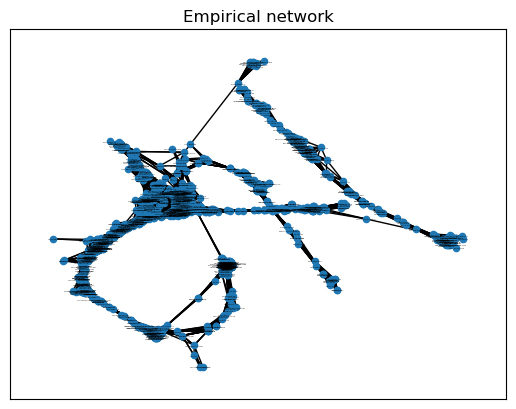

In [49]:
nx.draw_networkx(G, node_size=20,font_size=0)
plt.title('Empirical network')
plt.savefig('G.png', bbox_inches='tight', dpi=600)

In [25]:
## make a geoDataFrame 
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.Longitude, df.Latitude))
gdf = gdf.set_crs("EPSG:4326")
gdf

Station Name  \
21                    Hyatt at Fisherman's Wharf   
23                                  Palace Hotel   
24           Mark Hopkins InterContinental Hotel   
78                    Golden Gate Ferry Terminal   
79     Oakland International Airport - Daily Lot   
...                                          ...   
14083                       ORACLE SCA SCA12-002   
14097                  HGI   SUNNYVALE STATION 3   
14098                  HGI   SUNNYVALE STATION 1   
14110                1200 California Corporation   
14117            Zum Services Inc - Davidson Ave   

                     Street Address           City    ZIP   Latitude  \
21                   555 N Point St  San Francisco  94133  37.806190   
23              2 New Montgomery St  San Francisco  94105  37.788810   
24                999 California St  San Francisco  94108  37.791791   
78     101 E Sir Francis Drake Blvd       Larkspur  94939  37.944950   
79                     1 Airport Dr        Oakland  94621  37.713600   
...                             ...            ...    ...        ...   
14083              4140 Network Cir    Santa Clara  95054  37.395495   
14097            767 N Mathilda Ave      Sunnyvale  94085  37.394687   
14098            767 N Mathilda Ave      Sunnyvale  94085  37.394685   
14110        1200 California Street  San Francisco  94109  37.791743   
14117             1645 Davidson Ave  San Francisco  94124  37.745530   

        Longitude                     geometry  
21    -122.415200  POINT (-122.41520 37.80619)  
23    -122.401000  POINT (-122.40100 37.78881)  
24    -122.411265  POINT (-122.41127 37.79179)  
78    -122.509600  POINT (-122.50960 37.94495)  
79    -122.208700  POINT (-122.20870 37.71360)  
...           ...                          ...  
14083 -121.954533  POINT (-121.95453 37.39549)  
14097 -122.029707  POINT (-122.02971 37.39469)  
14098 -122.029664  POINT (-122.02966 37.39469)  
14110 -122.414455  POINT (-122.41446 37.79174)  
14117 -122.392720  POINT (-122.39272 37.74553)  

[3464 rows x 7 columns]

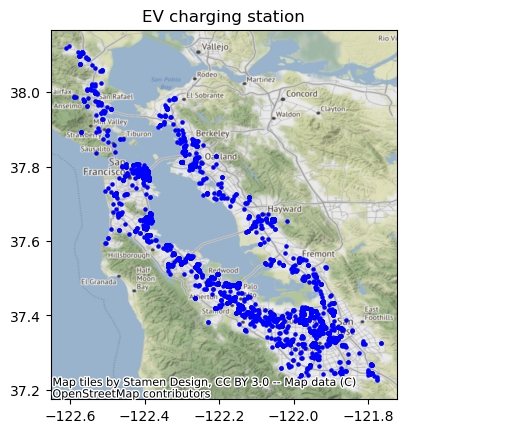

In [26]:
## plot each charging station on map

ax = gdf.plot(marker='o', color='blue', markersize=5)

# Add a basemap
ctx.add_basemap(ax, crs=gdf.crs.to_string())
ax.set(title='EV charging station')

plt.savefig('charging_stations_map.png', dpi=600)

# Random Graph model (eg. erdos_renyi_graph)
The probability p should be selected to get a similar average degree with the data (use the expression K(p,N))
Recall

$<k>= \frac{2*edges}{N}$

$<K> = p(N-1)\implies p = \frac{<K>}{N-1}$

Check out the documentation for Random Graph here!
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.erdos_renyi_graph.html

In [35]:
# Random graph 

N = G.number_of_nodes()
m = G.number_of_edges()

# Calculate the average degree of the data graph
k = 2 * m / N
print('k:',k)

# Choose a value of p that will result in a similar average degree for the random graph
p = k / (N - 1)
print('p:',p)

G_rand = nx.erdos_renyi_graph(N, p)
nx.draw_networkx(G_rand, node_size=30,font_size=3)
plt.title('Random graph model')
plt.savefig('G_rand.png', bbox_inches='tight', dpi=600)

# print("Average Clustering Coefficient <C>:", nx.average_clustering(G_rand))
# print("Average Degree <K>:", k)
# print("Average Shortest Path <l>:", nx.average_shortest_path_length(G_rand))
# print("Number of Nodes:", G_rand.number_of_nodes())
# print("Number of Links:", G_rand.number_of_edges())

k: 67.96488661302122
p: 0.049754675412167805


# Small world model(eg. Watts-Strogatz model)

For the Small World graph write the expression of the clustering coefficient as a function of the parameter value C(p)

$C(p) = C_0(1-p)^3$   ${\Rightarrow}$   $p=1-(\frac{C(p)}{C_0})^{1/3}$

Select N (to match the same number of nodes of the data), k the number of neighbors close to the  <𝐾>
  of the data, and p such that the clustering coefficient of the model resembles the data, to that end, from the expression of part 3. Fill the table with the values of the model you generated (1 pt)

Check out the documentation for Small World Graph here! https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.watts_strogatz_graph.html


In [34]:
# Generate a Watts-Strogatz model

# G = G.copy()

N = G.number_of_nodes() # number of nodes in the graph
print('node',N)
K = round(k) # number of edges, must be even integer
print('link:',K)
# Use your equation to solve for average clustering when c = p
Cp = nx.average_clustering(G)
print('Cp:',Cp)
C0 =  nx.average_clustering(nx.watts_strogatz_graph(N, K, 0 ))
print('C0:',C0)
p=1-pow(Cp/C0, 1/3)  # probability of rewiring each edge
print('p:',p)
G_ws = nx.watts_strogatz_graph(N, K, p)
nx.draw_networkx(G_ws, node_size=30,font_size=3)
plt.title('Small world model')
plt.savefig('G_ws.png', bbox_inches='tight', dpi=600)

# print("Average Clustering Coefficient <C>:", nx.average_clustering(G_ws))
# print("Average Degree <K>:", K)
# print("Average Shortest Path <l>:", nx.average_shortest_path_length(G_ws))
# print("Number of Nodes:", G_ws.number_of_nodes())
# print("Number of Links:", G_ws.number_of_edges())

node 1367
link: 68
Cp: 0.7848861518958574
C0: 0.7388059701492296
p: -0.020372526715580097


# Barabasi Albert graph

Use the same number of nodes and the expression of <K>(m) for the Barabasi Albert graph to select the parameter m such that the average of the model is similar to the data.

• Input parameters are (N, $k_{min}$) 
    
• $<k> =2k_{min} $
    
• Degree distribution power law $P(k)=2𝑘_{min} 𝑘^{-3}$ 
    
• Average shortest path length $<l>$ ~ log(N)/log$<k>$
    
• Clustering Coefficient C ~ $<k>$/N
    
    
Check out the documentation here:
https://networkx.org/documentation/stable/reference/generated/networkx.generators.random_graphs.barabasi_albert_graph.html

1367 34


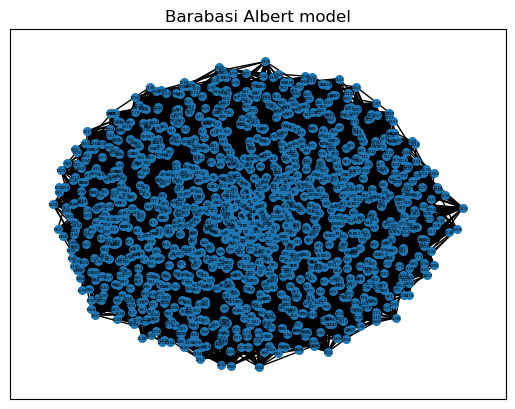

In [32]:
## Barabasi Albert graph

n = G.number_of_nodes()
k_min = round(k / 2)
print(n, k_min)
G_ba =nx.barabasi_albert_graph(n, k_min,seed=123)
nx.draw_networkx(G_ba, node_size=30,font_size=3)
plt.title('Barabasi Albert model')
plt.savefig('G_ba.png', bbox_inches='tight', dpi=600)

# print("Average Clustering Coefficient <C>:", nx.average_clustering(G_ba))
# print("Average Degree <K>:", K)
# print("Average Shortest Path <l>:", nx.average_shortest_path_length(G_ba))
# print("Number of Nodes:", G_ba.number_of_nodes())
# print("Number of Links:", G_ba.number_of_edges())
# print('C:',k_min/n)

In [36]:
data = {'Graph': ['My network', 'Random graph model', 'Small world model', 'Barabasi-Albert model'],
        'Avg Clustering Coefficient <C>': [nx.average_clustering(G), nx.average_clustering(G_rand), nx.average_clustering(G_ws), nx.average_clustering(G_ba)],
        'Avg Degree <k>': [G.number_of_edges()/G.number_of_nodes(), k, K, k_min],
        'Avg Shortest Path Length <l>': [nx.average_shortest_path_length(G), nx.average_shortest_path_length(G_rand), nx.average_shortest_path_length(G_ws), nx.average_shortest_path_length(G_ba)],
        '#Nodes': [G.number_of_nodes(), G_rand.number_of_nodes(), G_ws.number_of_nodes(), G_ba.number_of_nodes()],
        '#Links': [G.number_of_edges(), G_rand.number_of_edges(), G_ws.number_of_edges(), G_ba.number_of_edges()]
       }

model_data = pd.DataFrame(data)
model_data

Graph  Avg Clustering Coefficient <C>  Avg Degree <k>  \
0             My network                        0.784886       33.982443   
1     Random graph model                        0.049249       67.964887   
2      Small world model                        0.738806       68.000000   
3  Barabasi-Albert model                        0.111894       34.000000   

   Avg Shortest Path Length <l>  #Nodes  #Links  
0                     11.744445    1367   46454  
1                      1.983302    1367   46264  
2                     10.546120    1367   46478  
3                      2.012644    1367   45322

In [37]:

#G0:
degs0 = list(dict(nx.degree(G)).values())
n0, bins0 = np.histogram(degs0, bins = list(range(min(degs0), max(degs0)+1, 1)), density="True")

#G1:
degs1 = list(dict(nx.degree(G_rand)).values())
n1, bins1 = np.histogram(degs1, bins = list(range(min(degs1), max(degs1)+1, 1)), density="True")

#G2:
degs2 = list(dict(nx.degree(G_ws)).values())
n2, bins2 = np.histogram(degs2, bins = list(range(min(degs2), max(degs2)+1, 1)), density="True")

#G3:
degs3 = list(dict(nx.degree(G_ba)).values())
n3, bins3 = np.histogram(degs3, bins = list(range(min(degs3), max(degs3)+1, 1)), density="True")

#to plot:
plt.figure(figsize=(10,10)) #use once and set figure size
plt.axvline(x = 68, linewidth = 2, color = 'green', linestyle = '--')
plt.plot(bins0[:-1],n0,'r-', markersize=10, label="Empirical") 
plt.plot(bins1[:-1],n1,'b-', markersize=10, label="Random Graph") 
plt.plot(bins2[:-1],n2,'g-', markersize=10, label="Small World") 
plt.plot(bins3[:-1],n3,'y-', markersize=10, label="Barabasi Albert") 
plt.legend(loc='upper right', shadow=True)
plt.title('Degree Distributions')
plt.xlim([-10, 200])
plt.xlabel('degree, k')
plt.ylabel('P(k)')
plt.savefig('degree distributions.png', dpi=600)

In [50]:
from functools import reduce
import pathlib
import mapclassify as mc
pd.set_option('display.max_columns', None)

# API Libraries for the Census API
import json    
import requests

In [51]:
#Get key here: https://api.census.gov/data/key_signup.html

# Replace your key with the one below thanks!
key= '08feb1a6440c9034a3e563366ff570a40baf56f8'
key

'08feb1a6440c9034a3e563366ff570a40baf56f8'

In [52]:
B_C_vars_to_download = {
    "B01003_001E": "Total pop", # Total population
    "B19013_001E": "Median household income",  # median household income
    "B01002_001E": "Median age", # total median age
    "B15003_022E": "Total bachelor", # population with bachelor degree
    "B08015_001E": "Total cars", # Aggregate number of vehicles(car, van, truck) used in commutting by workers over age 16
    "B07013_003E": "Total household in rented home",  # population of household living in rented home
    
    "B08134_011E": "Total driving time to work", # time it takes to drive to workplace
    "B08134_012E": "Less than 10 mins driving time to work", # time it takes to drive to workplace
    "B08134_013E": "10-14 mins driving time to work", # time it takes to drive to workplace
    "B08134_014E": "15-19 mins driving time to work", # time it takes to drive to workplace
    "B08134_015E": "20-24 mins driving time to work", # time it takes to drive to workplace
    "B08134_016E": "25-29 mins driving time to work", # time it takes to drive to workplace
    "B08134_017E": "30-34 mins driving time to work", # time it takes to drive to workplace
    "B08134_018E": "35-44 mins driving time to work", # time it takes to drive to workplace
    "B08134_019E": "45-59 mins driving time to work", # time it takes to drive to workplace
    "B08134_020E": "More than 60 mins driving time to work", # time it takes to drive to workplace
}

B_C_vars_to_download_list = list(B_C_vars_to_download.keys())
B_C_vars_to_download_list

B_C_var_str = ','.join(B_C_vars_to_download_list)
B_C_var_str

'B01003_001E,B19013_001E,B01002_001E,B15003_022E,B08015_001E,B07013_003E,B08134_011E,B08134_012E,B08134_013E,B08134_014E,B08134_015E,B08134_016E,B08134_017E,B08134_018E,B08134_019E,B08134_020E'

In [53]:
# Defining the url
state = '06'
county = {'001', '013', '041', '055', '075', '081', '085', '095', '097'}
county= ','.join(county)

year = 2021


url_B_C = "https://api.census.gov/data/{0}/acs/acs5?get={1}&for=tract:*&in=state:{2}&in=county:{3}&in=tract:*&key={4}".format(
        year, B_C_var_str, state, county, key)


print (f'{url_B_C}')

print(county)

https://api.census.gov/data/2021/acs/acs5?get=B01003_001E,B19013_001E,B01002_001E,B15003_022E,B08015_001E,B07013_003E,B08134_011E,B08134_012E,B08134_013E,B08134_014E,B08134_015E,B08134_016E,B08134_017E,B08134_018E,B08134_019E,B08134_020E&for=tract:*&in=state:06&in=county:055,081,085,075,097,041,001,095,013&in=tract:*&key=08feb1a6440c9034a3e563366ff570a40baf56f8
055,081,085,075,097,041,001,095,013


In [54]:
# Retrieve data from the Census and converts it into a dataframe
res = requests.get(url_B_C)
acs_det = pd.DataFrame(res.json())
acs_det.columns = acs_det.iloc[0]
acs_det = acs_det.drop(0).reset_index(drop = True)

In [55]:
# Converting Census values from string to numeric type to be able to do calculations
col = acs_det.columns.tolist()
col = [i for i in col if i not in ['state', 'county', 'tract']]
acs_det[col] = acs_det[col].astype(float)

In [126]:
# replace the error value with NaN
acs_det = acs_det.replace(-666666666.0, float('NaN'))

# drop any rows that contain NaN
acs_det = acs_det.dropna()

acs_det

0     B01003_001E  B19013_001E  B01002_001E  B15003_022E  B08015_001E  \
0          3324.0     224821.0         50.2        947.0        755.0   
1          2038.0     201154.0         38.9        565.0        300.0   
2          5449.0     127333.0         38.7       1728.0       1070.0   
3          4384.0     146265.0         36.6       1187.0       1020.0   
4          4048.0     101597.0         36.5       1051.0        995.0   
...           ...          ...          ...          ...          ...   
1766       2109.0      63269.0         47.3        305.0        635.0   
1767       2237.0     116284.0         54.0        561.0        550.0   
1768       1684.0      78542.0         61.0        587.0        510.0   
1769        749.0      82656.0         64.2        215.0        170.0   
1770        775.0      75197.0         68.4        215.0        130.0   

0     B07013_003E  B08134_011E  B08134_012E  B08134_013E  B08134_014E  \
0           519.0        820.0         40.0         94.0        175.0   
1           770.0        335.0         12.0         35.0         83.0   
2          2914.0       1148.0         17.0        116.0        302.0   
3          2108.0       1138.0         32.0        306.0        120.0   
4          1969.0       1080.0         71.0        105.0        323.0   
...           ...          ...          ...          ...          ...   
1766        718.0        687.0        106.0          5.0         27.0   
1767        594.0        642.0          9.0          0.0        110.0   
1768        378.0        530.0         45.0          0.0        111.0   
1769        119.0        175.0         20.0         85.0          3.0   
1770        176.0        132.0         33.0         43.0          0.0   

0     B08134_015E  B08134_016E  B08134_017E  B08134_018E  B08134_019E  \
0           145.0         21.0        128.0         78.0         61.0   
1            46.0         10.0         25.0         38.0         54.0   
2           102.0        117.0        143.0         51.0         65.0   
3            99.0        107.0        156.0         72.0         83.0   
4           153.0          0.0        229.0         63.0         77.0   
...           ...          ...          ...          ...          ...   
1766         89.0         18.0         18.0         49.0        204.0   
1767         27.0        162.0         80.0        118.0         76.0   
1768         39.0         48.0        102.0        100.0         43.0   
1769          3.0          3.0          5.0         19.0         23.0   
1770          0.0         11.0         13.0          0.0          0.0   

0     B08134_020E state county   tract  
0            78.0    06    001  400100  
1            32.0    06    001  400200  
2           235.0    06    001  400300  
3           163.0    06    001  400400  
4            59.0    06    001  400500  
...           ...   ...    ...     ...  
1766        171.0    06    097  154304  
1767         60.0    06    097  154305  
1768         42.0    06    097  154306  
1769         14.0    06    097  154307  
1770         32.0    06    097  154308  

[1721 rows x 19 columns]

In [57]:
!pip install cenpy
import cenpy

In [127]:
## Getting the shapes
# From the acs variable you can extract the MSA or CSA you wish to choose
# Documentation for cenpy products http://cenpy-devs.github.io/cenpy/generated/cenpy.products.ACS.html

# The year can be changed depending on the question you are trying to answer
acs = cenpy.products.ACS(2019)

# Here we use from_county but do change this depending on the question you are trying to answer
db = acs.from_csa("San Jose-San Francisco-Oakland, CA",
                  level="tract",
                  variables=B_C_var_str
                 )
 ## replace variables with vars_to_download_l from above

 # Remember to pick ONE variable of interest when plotting

# f, ax = plt.subplots(1,1,figsize=(20,20))
# db.dropna(subset=['B17006_007E'], axis=0).plot('B17006_007E', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')

In [128]:
db

GEOID                                           geometry  \
0     06097990100  POLYGON ((-13762706.610 4687083.180, -13761997...   
1     06075980401  POLYGON ((-13711647.480 4547791.830, -13711635...   
2     06081612700  POLYGON ((-13603249.680 4500745.130, -13603146...   
3     06081612000  POLYGON ((-13598390.690 4504780.430, -13598369...   
4     06081612100  POLYGON ((-13598117.850 4502972.090, -13598103...   
...           ...                                                ...   
1929  06099002701  POLYGON ((-13465889.440 4526163.430, -13465889...   
1930  06099002605  POLYGON ((-13463858.860 4524354.770, -13463858...   
1931  06077004902  POLYGON ((-13486050.400 4566015.310, -13485973...   
1932  06099003909  POLYGON ((-13456035.220 4512110.920, -13456017...   
1933  06099003905  POLYGON ((-13451642.770 4509065.350, -13451614...   

                                                   NAME state county   tract  
0          Census Tract 9901, Sonoma County, California    06    097  990100  
1     Census Tract 9804.01, San Francisco County, Ca...    06    075  980401  
2       Census Tract 6127, San Mateo County, California    06    081  612700  
3       Census Tract 6120, San Mateo County, California    06    081  612000  
4       Census Tract 6121, San Mateo County, California    06    081  612100  
...                                                 ...   ...    ...     ...  
1929  Census Tract 27.01, Stanislaus County, California    06    099  002701  
1930  Census Tract 26.05, Stanislaus County, California    06    099  002605  
1931  Census Tract 49.02, San Joaquin County, Califo...    06    077  004902  
1932  Census Tract 39.09, Stanislaus County, California    06    099  003909  
1933  Census Tract 39.05, Stanislaus County, California    06    099  003905  

[1934 rows x 6 columns]

In [129]:
acs_det

0     B01003_001E  B19013_001E  B01002_001E  B15003_022E  B08015_001E  \
0          3324.0     224821.0         50.2        947.0        755.0   
1          2038.0     201154.0         38.9        565.0        300.0   
2          5449.0     127333.0         38.7       1728.0       1070.0   
3          4384.0     146265.0         36.6       1187.0       1020.0   
4          4048.0     101597.0         36.5       1051.0        995.0   
...           ...          ...          ...          ...          ...   
1766       2109.0      63269.0         47.3        305.0        635.0   
1767       2237.0     116284.0         54.0        561.0        550.0   
1768       1684.0      78542.0         61.0        587.0        510.0   
1769        749.0      82656.0         64.2        215.0        170.0   
1770        775.0      75197.0         68.4        215.0        130.0   

0     B07013_003E  B08134_011E  B08134_012E  B08134_013E  B08134_014E  \
0           519.0        820.0         40.0         94.0        175.0   
1           770.0        335.0         12.0         35.0         83.0   
2          2914.0       1148.0         17.0        116.0        302.0   
3          2108.0       1138.0         32.0        306.0        120.0   
4          1969.0       1080.0         71.0        105.0        323.0   
...           ...          ...          ...          ...          ...   
1766        718.0        687.0        106.0          5.0         27.0   
1767        594.0        642.0          9.0          0.0        110.0   
1768        378.0        530.0         45.0          0.0        111.0   
1769        119.0        175.0         20.0         85.0          3.0   
1770        176.0        132.0         33.0         43.0          0.0   

0     B08134_015E  B08134_016E  B08134_017E  B08134_018E  B08134_019E  \
0           145.0         21.0        128.0         78.0         61.0   
1            46.0         10.0         25.0         38.0         54.0   
2           102.0        117.0        143.0         51.0         65.0   
3            99.0        107.0        156.0         72.0         83.0   
4           153.0          0.0        229.0         63.0         77.0   
...           ...          ...          ...          ...          ...   
1766         89.0         18.0         18.0         49.0        204.0   
1767         27.0        162.0         80.0        118.0         76.0   
1768         39.0         48.0        102.0        100.0         43.0   
1769          3.0          3.0          5.0         19.0         23.0   
1770          0.0         11.0         13.0          0.0          0.0   

0     B08134_020E state county   tract  
0            78.0    06    001  400100  
1            32.0    06    001  400200  
2           235.0    06    001  400300  
3           163.0    06    001  400400  
4            59.0    06    001  400500  
...           ...   ...    ...     ...  
1766        171.0    06    097  154304  
1767         60.0    06    097  154305  
1768         42.0    06    097  154306  
1769         14.0    06    097  154307  
1770         32.0    06    097  154308  

[1721 rows x 19 columns]

In [130]:
df = pd.merge(db, acs_det, on=['tract'])
df


GEOID                                           geometry  \
0     06081612700  POLYGON ((-13603249.680 4500745.130, -13603146...   
1     06081611700  POLYGON ((-13602027.170 4507231.160, -13602024...   
2     06085510803  POLYGON ((-13595075.040 4497792.420, -13595074...   
3     06085510801  POLYGON ((-13594622.310 4499094.780, -13594583...   
4     06085509404  POLYGON ((-13593617.090 4495167.600, -13593605...   
...           ...                                                ...   
1393  06013312000  POLYGON ((-13567950.050 4581620.760, -13567924...   
1394  06013307101  POLYGON ((-13561560.080 4576949.990, -13561550...   
1395  06013308001  POLYGON ((-13559846.650 4579149.080, -13559844...   
1396  06013302009  POLYGON ((-13554937.350 4576839.260, -13554804...   
1397  06013302007  POLYGON ((-13549383.290 4578725.440, -13549382...   

                                                   NAME state_x county_x  \
0       Census Tract 6127, San Mateo County, California      06      081   
1       Census Tract 6117, San Mateo County, California      06      081   
2     Census Tract 5108.03, Santa Clara County, Cali...      06      085   
3     Census Tract 5108.01, Santa Clara County, Cali...      06      085   
4     Census Tract 5094.04, Santa Clara County, Cali...      06      085   
...                                                 ...     ...      ...   
1393  Census Tract 3120, Contra Costa County, Califo...      06      013   
1394  Census Tract 3071.01, Contra Costa County, Cal...      06      013   
1395  Census Tract 3080.01, Contra Costa County, Cal...      06      013   
1396  Census Tract 3020.09, Contra Costa County, Cal...      06      013   
1397  Census Tract 3020.07, Contra Costa County, Cal...      06      013   

       tract  B01003_001E  B19013_001E  B01002_001E  B15003_022E  B08015_001E  \
0     612700       2113.0     250001.0         46.9        565.0        505.0   
1     611700       5694.0     105583.0         34.5        471.0       2175.0   
2     510803       3331.0     184919.0         41.6        590.0       1075.0   
3     510801       5802.0     200469.0         42.3       1355.0       1515.0   
4     509404       6436.0     133750.0         36.1        988.0       2130.0   
...      ...          ...          ...          ...          ...          ...   
1393  312000       2692.0      49663.0         30.2        191.0        635.0   
1394  307101       4719.0      69784.0         37.8        430.0       1450.0   
1395  308001       7757.0      74245.0         37.3        579.0       2260.0   
1396  302009       7078.0     114943.0         36.2       1108.0       2935.0   
1397  302007       6659.0      87649.0         35.6        462.0       2175.0   

      B07013_003E  B08134_011E  B08134_012E  B08134_013E  B08134_014E  \
0           348.0        513.0         98.0         99.0         30.0   
1          2312.0       2348.0         71.0        236.0        262.0   
2          1931.0       1135.0        213.0         78.0        181.0   
3          1713.0       1627.0        133.0        172.0        349.0   
4          4330.0       2307.0         61.0        528.0        404.0   
...           ...          ...          ...          ...          ...   
1393       1275.0        691.0         55.0         43.0         46.0   
1394       1301.0       1704.0        233.0        244.0        262.0   
1395       2165.0       2412.0        147.0        426.0        141.0   
1396       2047.0       3337.0        239.0        360.0        215.0   
1397       1827.0       2279.0        317.0        388.0        201.0   

      B08134_015E  B08134_016E  B08134_017E  B08134_018E  B08134_019E  \
0            38.0         29.0        110.0         48.0         10.0   
1           726.0        182.0        413.0        109.0        158.0   
2           395.0         40.0        160.0         17.0         51.0   
3           456.0        115.0        239.0         28.0         46.0   
4           600.0  

In [131]:
# Load the charging stations and census tracts dataframes
charging_stations = gdf
census_tracts = df

# reproject the charging stations to match the CRS of the census tracts
charging_stations = charging_stations.to_crs(census_tracts.crs)

# perform a spatial join to count the number of charging stations in each census tract
charging_counts = gpd.sjoin(charging_stations, census_tracts, how='left', op='within').groupby('GEOID')['geometry'].count()

# print(charging_counts)

# merge the charging station counts back into the census tract dataframe
census_tracts = pd.merge(census_tracts, charging_counts, on='GEOID', how='right')
census_tracts.rename(columns={'geometry_y': 'charging_stations_count'}, inplace=True)
census_tracts.rename(columns={'geometry_x': 'geometry'}, inplace=True)

# map old column names to new column names
census_tracts = census_tracts.rename(columns=B_C_vars_to_download)

census_tracts["pct_bachelor"] = census_tracts["Total bachelor"] / \
                  (census_tracts["Total pop"] + \
                   (census_tracts["Total pop"]==0) * 1
                  )
census_tracts["pct_rented_home"] = census_tracts["Total household in rented home"] / \
                  (census_tracts["Total pop"] + \
                   (census_tracts["Total pop"]==0) * 1
                  )
census_tracts["pct_car"] = census_tracts["Total cars"] / \
                  (census_tracts["Total pop"] + \
                   (census_tracts["Total pop"]==0) * 1
                  )
census_tracts["charging_stations_per_car"] = census_tracts["charging_stations_count"] / \
                  (census_tracts["Total cars"] + \
                   (census_tracts["Total cars"]==0) * 1
                  )
census_tracts["charging_stations_per_person"] = census_tracts["charging_stations_count"] / \
                  (census_tracts["Total pop"] + \
                   (census_tracts["Total pop"]==0) * 1
                  )

census_tracts=census_tracts.dropna()
census_tracts

GEOID                                           geometry  \
0    06001400100  POLYGON ((-13608464.890 4563254.660, -13608436...   
1    06001400300  POLYGON ((-13610547.780 4556514.550, -13610540...   
2    06001401200  POLYGON ((-13610154.050 4554533.330, -13610152...   
3    06001401300  POLYGON ((-13611411.960 4553003.530, -13611390...   
4    06001401700  POLYGON ((-13619570.230 4552764.550, -13618930...   
..           ...                                                ...   
335  06085512024  POLYGON ((-13567249.850 4475827.170, -13567239...   
336  06085512027  POLYGON ((-13567173.260 4474814.690, -13567147...   
337  06085512032  POLYGON ((-13557718.890 4470546.640, -13557714...   
338  06085512034  POLYGON ((-13556364.140 4470468.910, -13556359...   
339  06085512052  POLYGON ((-13567098.010 4474125.340, -13567086...   

                                                  NAME state_x county_x  \
0        Census Tract 4001, Alameda County, California      06      001   
1        Census Tract 4003, Alameda County, California      06      001   
2        Census Tract 4012, Alameda County, California      06      001   
3        Census Tract 4013, Alameda County, California      06      001   
4        Census Tract 4017, Alameda County, California      06      001   
..                                                 ...     ...      ...   
335  Census Tract 5120.24, Santa Clara County, Cali...      06      085   
336  Census Tract 5120.27, Santa Clara County, Cali...      06      085   
337  Census Tract 5120.32, Santa Clara County, Cali...      06      085   
338  Census Tract 5120.34, Santa Clara County, Cali...      06      085   
339  Census Tract 5120.52, Santa Clara County, Cali...      06      085   

      tract  Total pop  Median household income  Median age  Total bachelor  \
0    400100     3324.0                 224821.0        50.2           947.0   
1    400300     5449.0                 127333.0        38.7          1728.0   
2    401200     2800.0                 103824.0        38.1           959.0   
3    401300     4074.0                  91225.0        35.9          1090.0   
4    401700     3379.0                 126728.0        36.6           995.0   
..      ...        ...                      ...         ...             ...   
335  512024     5125.0                 126216.0        40.8          1235.0   
336  512027     4354.0                  92295.0        42.7          1040.0   
337  512032     3245.0                 141184.0        42.3           788.0   
338  512034     2832.0                 133125.0        42.6           596.0   
339  512052     4060.0                 109208.0        42.1           760.0   

     Total cars  Total household in rented home  Total driving time to work  \
0         755.0                           519.0                       820.0   
1        1070.0                          2914.0                      1148.0   
2         700.0                          1424.0                       761.0   
3         925.0                          2748.0                       994.0   
4        1035.0                          1564.0                      1228.0   
..          ...                             ...                         ...   
335      2050.0                          2456.0                      2184.0   
336      1460.0                          2205.0                      1588.0   
337      1120.0                           666.0                      1189.0   
338      1045.0                           269.0                      1159.0   
339      1650.0                          1976.0                      1764.0   

     Less than 10 mins driving time to work  10-14 mins driving time to work  \
0                                      40.0                             94.0   
1                                      17.0                            116.0   
2                                      43.0                             31.0   
3                                      

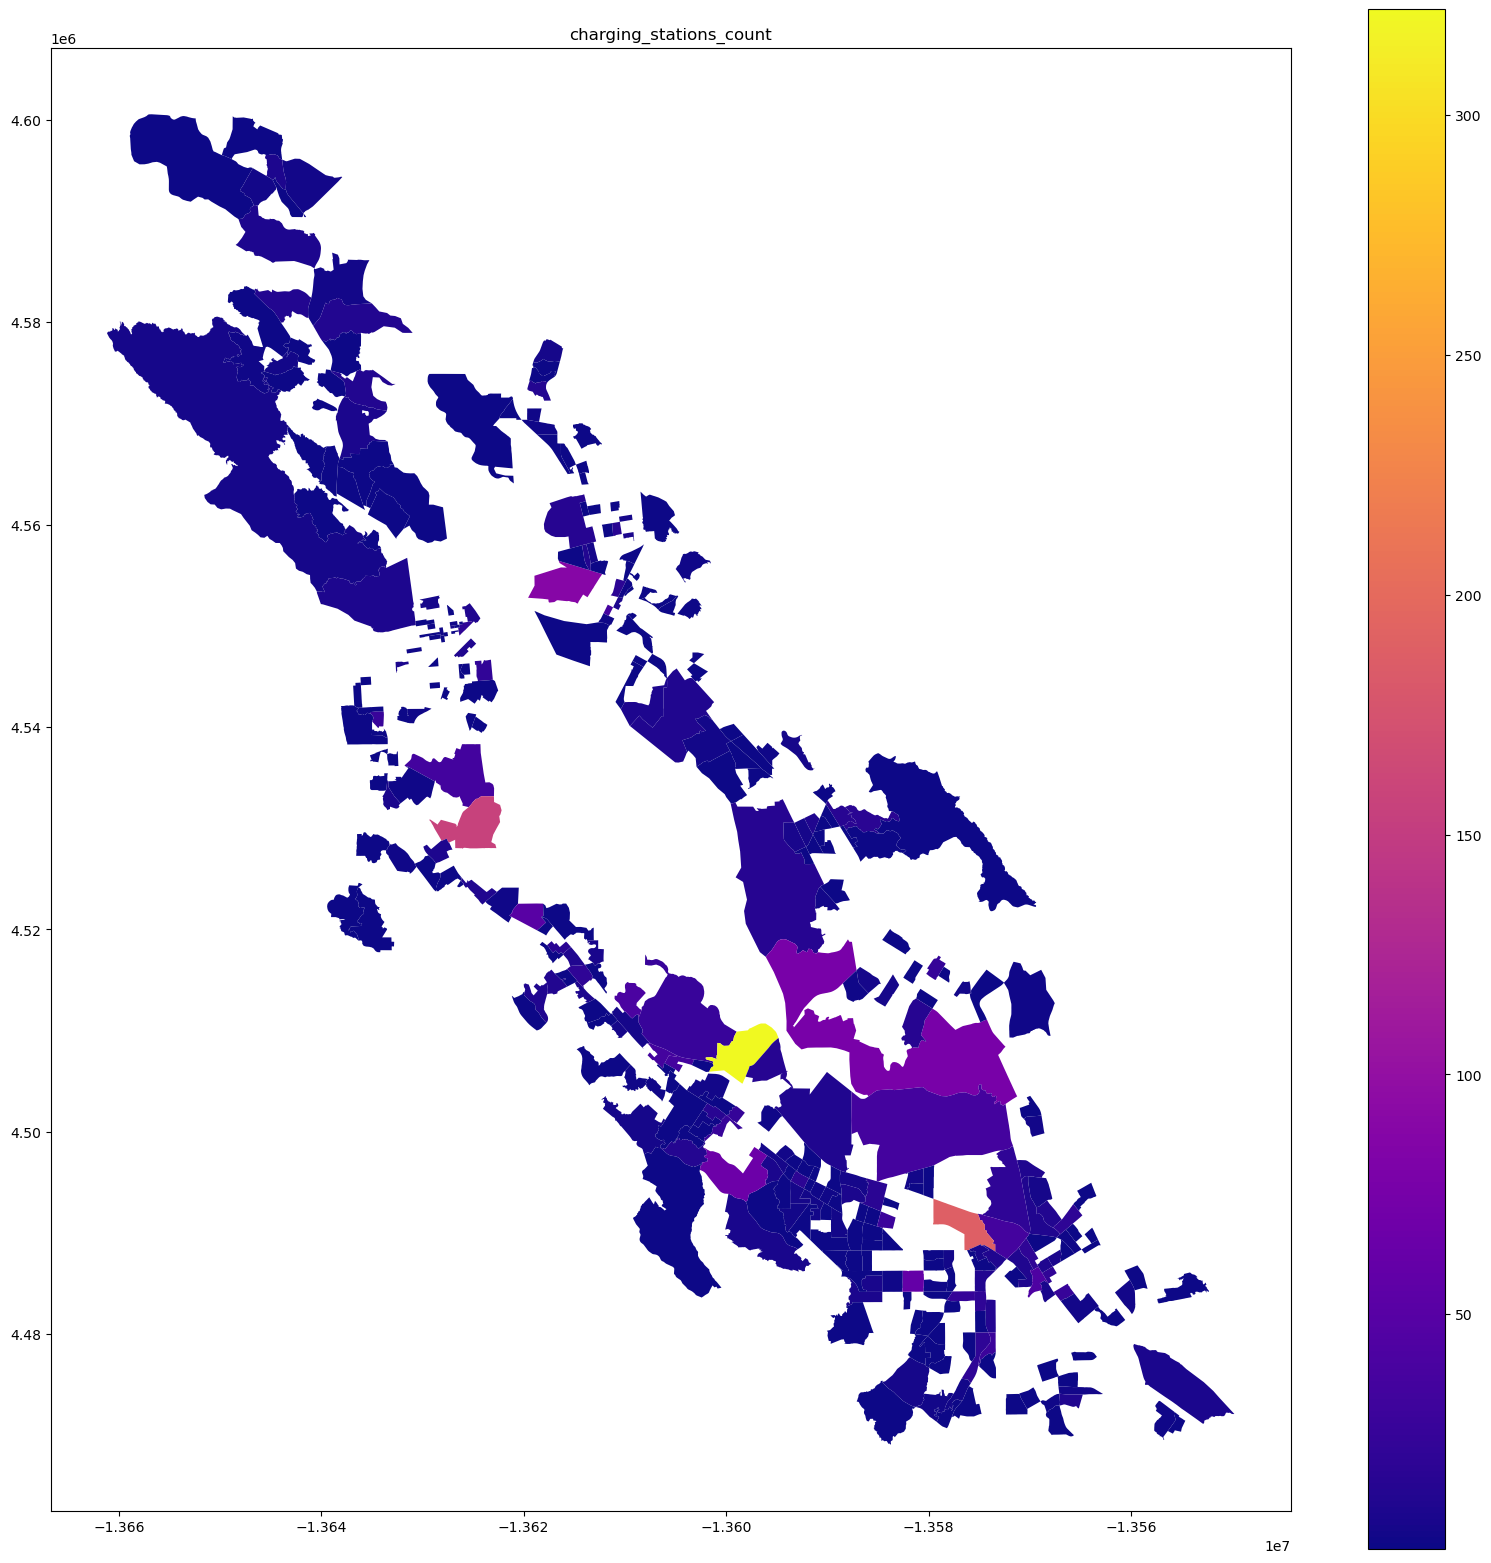

In [132]:
# Remember to pick ONE variable of interest when plotting

f, ax = plt.subplots(1,1,figsize=(20,20))
census_tracts.dropna(subset=['charging_stations_count'], axis=0).plot('charging_stations_count', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_count')
plt.savefig('charging_stations_count', bbox_inches='tight', dpi=600)


# K-means


In [64]:
!pip install esda
from esda.moran import Moran
import libpysal.weights.set_operations as Wsets
from libpysal.weights import Queen, KNN
from sklearn.cluster import KMeans, AgglomerativeClustering
import seaborn as sns

In [208]:
cluster_variables =  [
    'charging_stations_per_person',   # charing stations divide by total cars
#     'charging_stations_count', 
    'Median household income', # Median household income
    'Median age',         # Median age of tract population
    'pct_rented_home',         # Percent of households that are rented
    'pct_bachelor',       # Percent of tract population with a Bachelors degree
    'pct_car',            # Car available divide by total pop
    
]

In [209]:
cluster_variables

['charging_stations_per_person',
 'Median household income',
 'Median age',
 'pct_rented_home',
 'pct_bachelor',
 'pct_car']

KeyError: 'charging_stations_per_person'

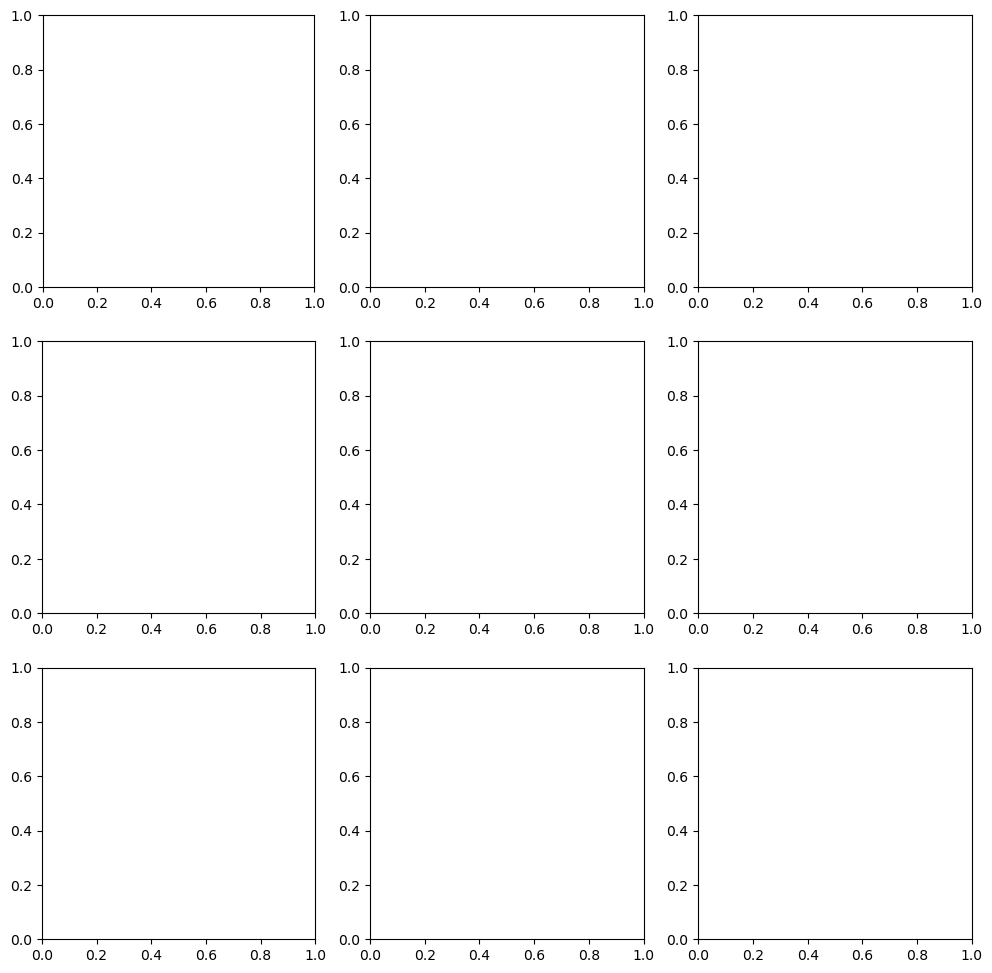

In [210]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(column=col, ax=ax, scheme='Quantiles', 
            linewidth=0, cmap='plasma',legend=True,legend_kwds={'fontsize':'xx-small'})
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
#     plt.savefig('msps_variables.png')
# Display the figure
plt.show()

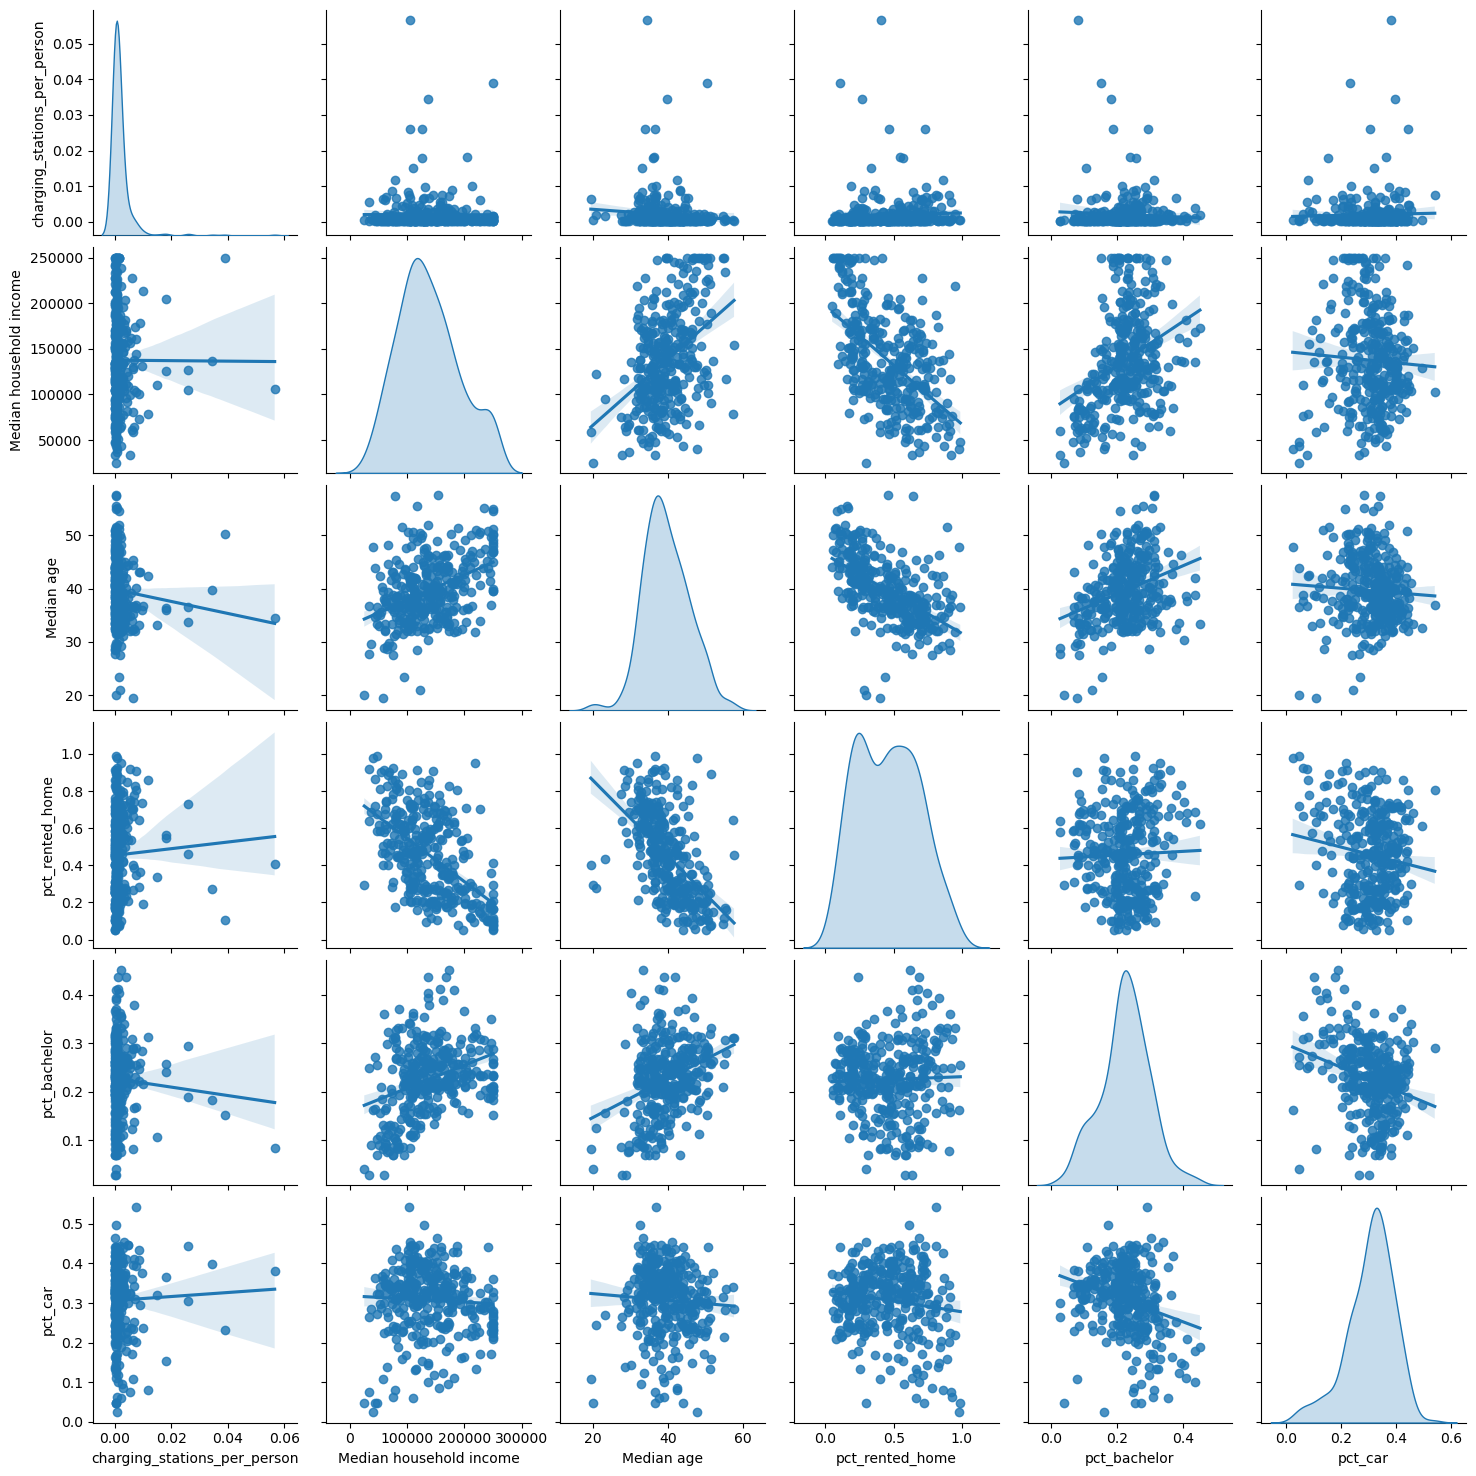

In [212]:
_=sns.pairplot(census_tracts[cluster_variables], kind='reg', diag_kind='kde')
plt.show()

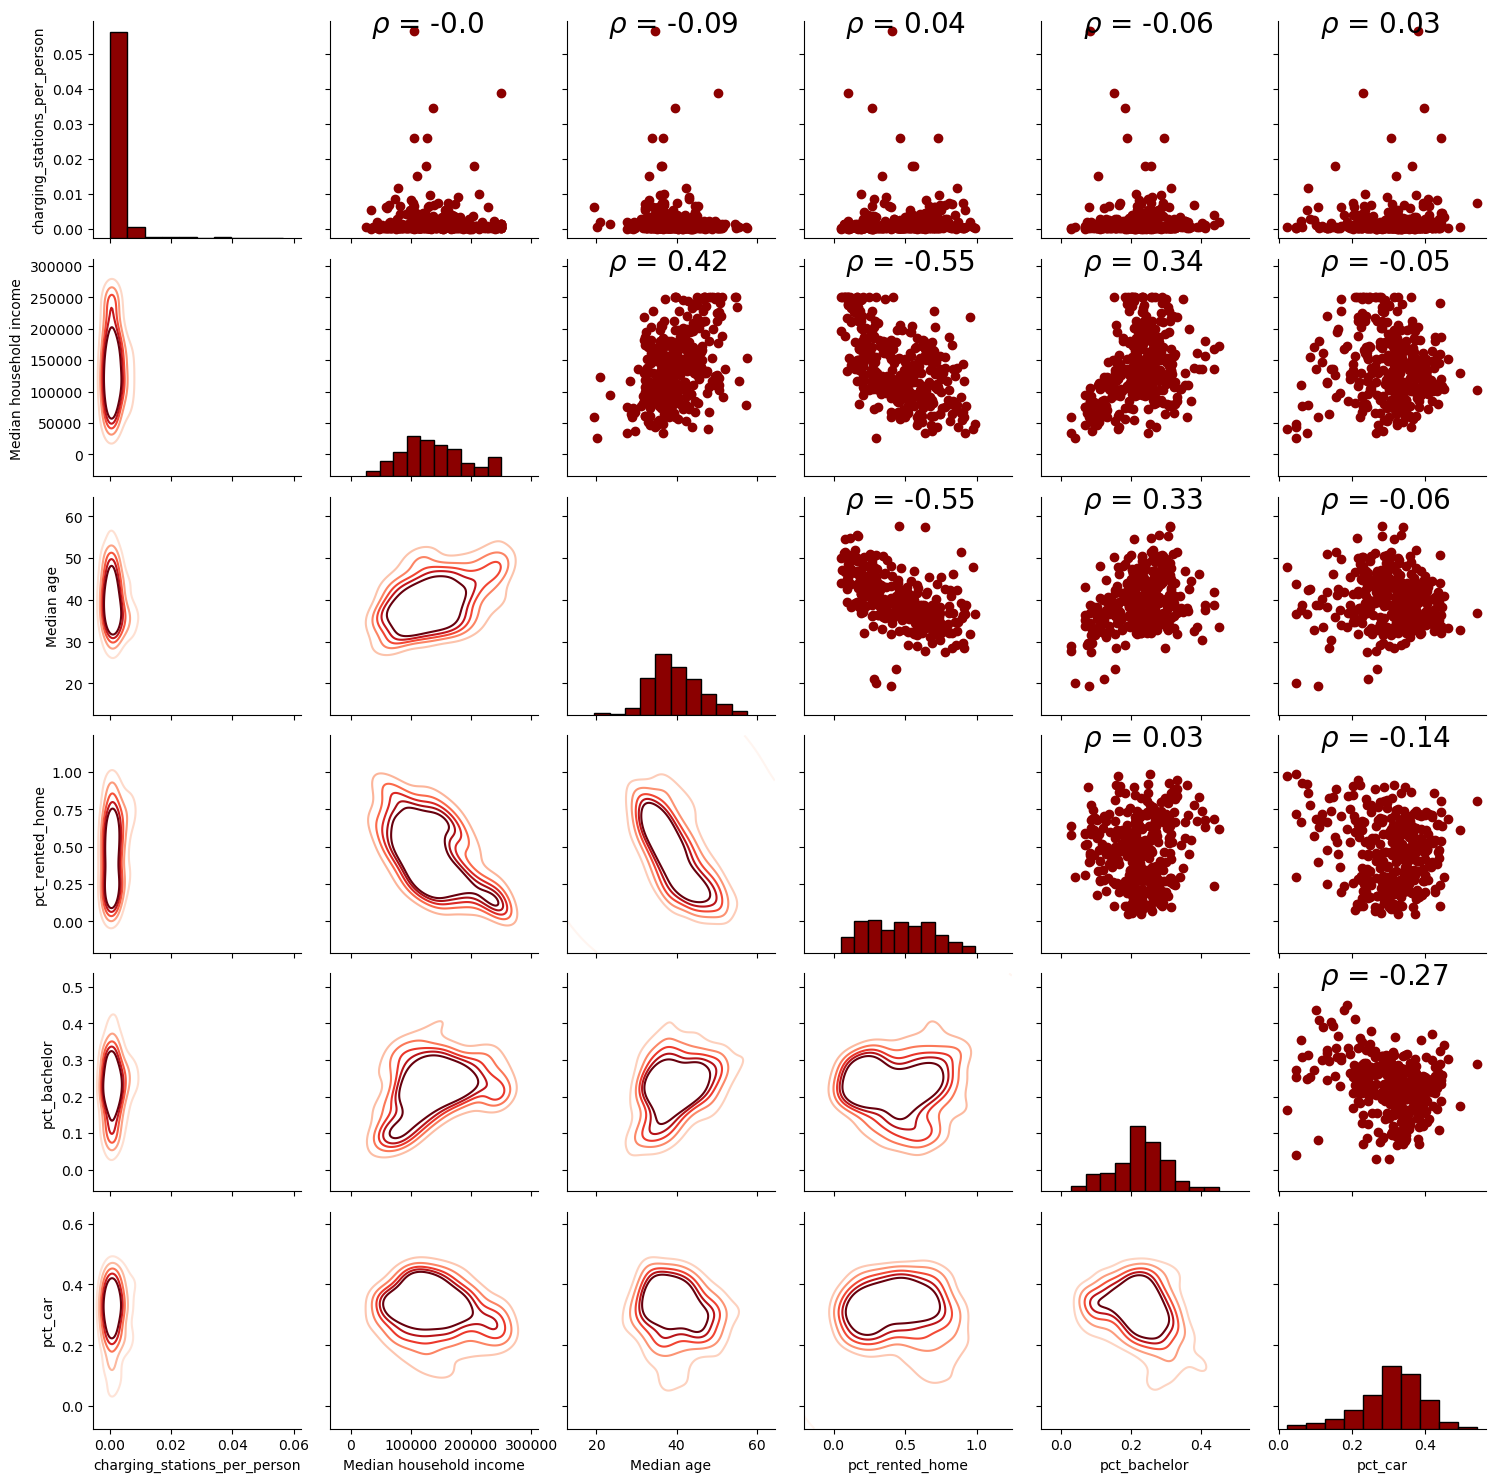

In [213]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)


grid = sns.PairGrid(census_tracts[cluster_variables])
# Map the plots to the locations
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds', levels = np.linspace(0, 0.5, 6))
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');
plt.savefig('PairGrid.png')
plt.show()


In [138]:
census_cluster=census_tracts[cluster_variables]

In [139]:
import sklearn.cluster as cluster

In [140]:
K=range(1,12)
wss = []
for k in K:
    kmeans=cluster.KMeans(n_clusters=k,init="k-means++")
    kmeans=kmeans.fit(census_cluster)
    wss_iter = kmeans.inertia_
    wss.append(wss_iter)

In [141]:
mycenters = pd.DataFrame({'Clusters' : K, 'WSS' : wss})
mycenters

Clusters           WSS
0          1  9.687277e+11
1          2  3.168702e+11
2          3  1.502637e+11
3          4  7.988096e+10
4          5  5.116226e+10
5          6  3.707823e+10
6          7  2.519635e+10
7          8  1.845990e+10
8          9  1.508075e+10
9         10  1.205909e+10
10        11  9.648594e+09

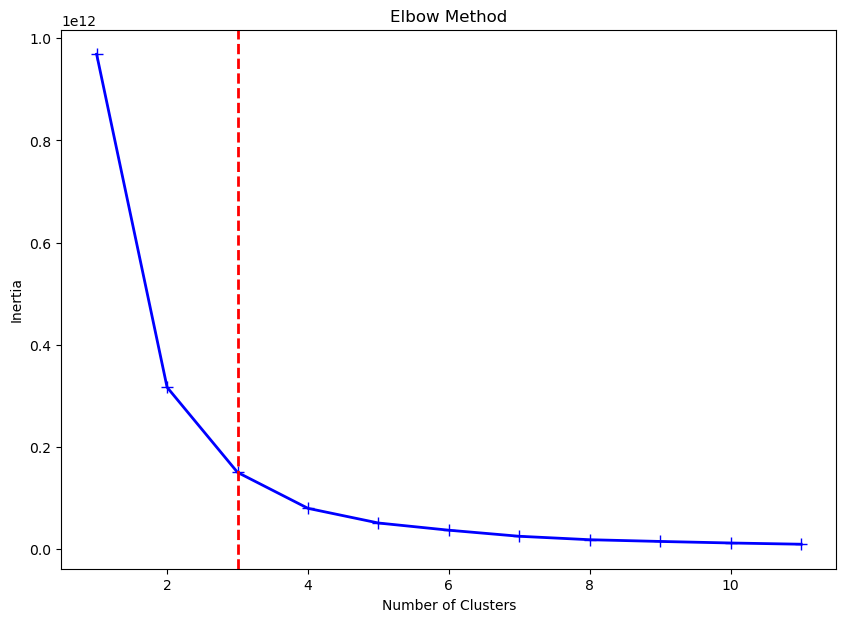

In [142]:
# Using elbow method to select the correct number of clusters

_ = plt.figure(figsize = (10,7))
_ = plt.plot(range(1,12), wss, linewidth = 2, color = 'blue', marker='+', markersize = 8)
_ = plt.title('Elbow Method', fontsize = 12)
_ = plt.xlabel('Number of Clusters',fontsize = 10)
_ = plt.ylabel('Inertia',fontsize = 10)

n_clusters = 3
_ = plt.axvline(x = n_clusters, linewidth = 2, color = 'red', linestyle = '--')
plt.savefig('Elbow method', bbox_inches='tight', dpi=600)
_ = plt.show()

In [143]:
# Initialise KMeans instance
kmeans = KMeans(n_clusters=3)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(census_cluster)
k5cls.labels_

array([2, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2,
       0, 0, 2, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 2, 1, 0,
       2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 2, 0, 0,
       1, 1, 1, 0, 0, 0, 2, 2, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 2,
       1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 2, 2, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 2, 1, 1, 0, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 2, 0, 0,
       2, 0, 2, 2, 2, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0,

In [144]:
census_cluster

charging_stations_per_person  Median household income  Median age  \
0                        0.000301                 224821.0        50.2   
1                        0.000184                 127333.0        38.7   
2                        0.000714                 103824.0        38.1   
3                        0.004418                  91225.0        35.9   
4                        0.026043                 126728.0        36.6   
..                            ...                      ...         ...   
335                      0.000195                 126216.0        40.8   
336                      0.000919                  92295.0        42.7   
337                      0.000924                 141184.0        42.3   
338                      0.000353                 133125.0        42.6   
339                      0.002463                 109208.0        42.1   

     pct_rented_home  pct_bachelor   pct_car  
0           0.156137      0.284898  0.227136  
1           0.534777      0.317122  0.196366  
2           0.508571      0.342500  0.250000  
3           0.674521      0.267550  0.227050  
4           0.462859      0.294466  0.306304  
..               ...           ...       ...  
335         0.479220      0.240976  0.400000  
336         0.506431      0.238861  0.335324  
337         0.205239      0.242835  0.345146  
338         0.094986      0.210452  0.368997  
339         0.486700      0.187192  0.406404  

[340 rows x 6 columns]

In [145]:
import matplotlib.colors as mcolors

# Assign labels into a column
census_tracts['k5cls'] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including 
# a legend and with no boundary lines
colors = ['#1f77b4', 'purple', 'orange']
cmap = mcolors.ListedColormap(colors)
census_tracts.plot(
    column='k5cls', categorical=True, legend=True, linewidth=0, ax=ax, cmap=cmap
)
# Remove axis
ax.set_axis_off()
plt.title('K-means clustering map')
plt.savefig('kmeans', bbox_inches='tight', dpi=600)
plt.show()

In [147]:
# Group data table by cluster label and count observations
k5sizes = census_tracts.groupby('k5cls').size()
k5sizes

k5cls
0    135
1    144
2     61
dtype: int64

In [148]:
_ = k5sizes.plot.bar()
plt.show()

In [149]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their mean
k5means = census_tracts.groupby('k5cls')[cluster_variables].mean()
k5means.T.round(2)

k5cls                                 0         1          2
charging_stations_per_person       0.00      0.00       0.00
Median household income       150494.24  88807.49  223789.85
Median age                        39.57     37.66      44.37
pct_rented_home                    0.45      0.56       0.24
pct_bachelor                       0.25      0.19       0.25
pct_car                            0.32      0.31       0.28

In [150]:
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = census_tracts.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())


	---------
	Cluster 0
                              count           mean           std  \
charging_stations_per_person  135.0       0.002046      0.004266   
Median household income       135.0  150494.237037  18597.368082   
Median age                    135.0      39.572593      5.311034   
pct_rented_home               135.0       0.446070      0.204989   
pct_bachelor                  135.0       0.248200      0.063548   
pct_car                       135.0       0.317616      0.083043   

                                        min            25%            50%  \
charging_stations_per_person       0.000125       0.000283       0.000645   
Median household income       119821.000000  134197.500000  150000.000000   
Median age                        21.000000      35.900000      39.000000   
pct_rented_home                    0.094986       0.267213       0.421969   
pct_bachelor                       0.124303       0.210489       0.242835   
pct_car                            0.0

In [151]:
# Index db on cluster ID
tidy_db = census_tracts.set_index('k5cls')
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining 
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(columns={
                        'level_1': 'Attribute', 
                        0: 'Values'})
# Check out result
tidy_db

k5cls                     Attribute         Values
0         2  charging_stations_per_person       0.000301
1         2       Median household income  224821.000000
2         2                    Median age      50.200000
3         2               pct_rented_home       0.156137
4         2                  pct_bachelor       0.284898
...     ...                           ...            ...
2035      1       Median household income  109208.000000
2036      1                    Median age      42.100000
2037      1               pct_rented_home       0.486700
2038      1                  pct_bachelor       0.187192
2039      1                       pct_car       0.406404

[2040 rows x 3 columns]

In [152]:
## find the value for cluster 1 and 2
selected_rows = tidy_db[(tidy_db['k5cls']==1) | (tidy_db['k5cls']==2)]
print(selected_rows)

# Extract values for k5cls=1
cls_1 = tidy_db.loc[tidy_db['k5cls'] == 1, 'Values'].tolist()
print(cls_1)

# Extract values for k5cls=2
cls_2 = tidy_db.loc[tidy_db['k5cls'] == 2, 'Values'].tolist()
print(cls_2)

      k5cls                     Attribute         Values
0         2  charging_stations_per_person       0.000301
1         2       Median household income  224821.000000
2         2                    Median age      50.200000
3         2               pct_rented_home       0.156137
4         2                  pct_bachelor       0.284898
...     ...                           ...            ...
2035      1       Median household income  109208.000000
2036      1                    Median age      42.100000
2037      1               pct_rented_home       0.486700
2038      1                  pct_bachelor       0.187192
2039      1                       pct_car       0.406404

[1230 rows x 3 columns]
[0.0007142857142857143, 103824.0, 38.1, 0.5085714285714286, 0.3425, 0.25, 0.004418262150220913, 91225.0, 35.9, 0.6745213549337261, 0.26755031909671084, 0.2270495827196858, 0.005494505494505495, 33523.0, 36.7, 0.9169719169719169, 0.24847374847374848, 0.07631257631257632, 0.000644468313641245

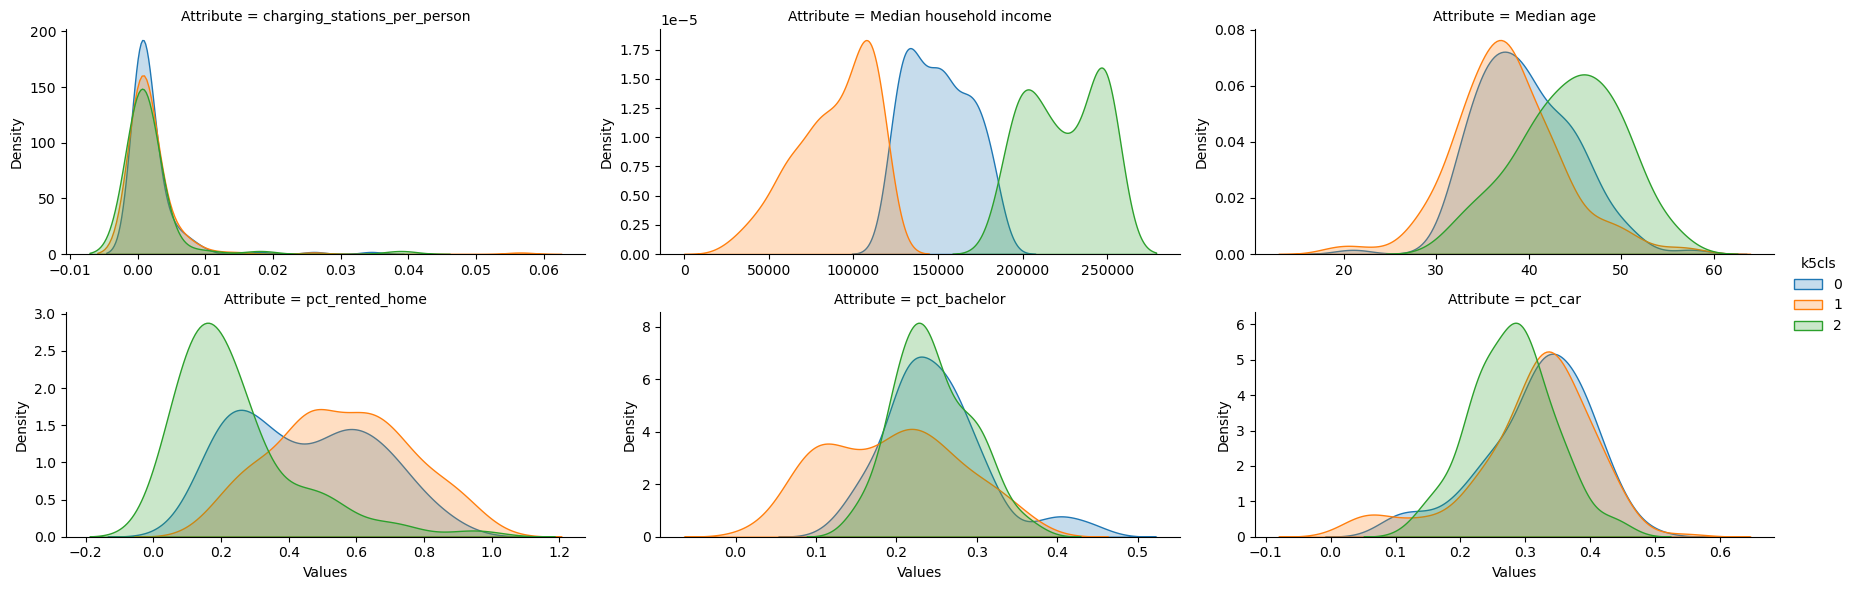

In [153]:
import warnings

warnings.filterwarnings("ignore")

# Setup the facets with custom color palette
facets = sns.FacetGrid(data=tidy_db, col='Attribute', hue='k5cls',
                       sharey=False, sharex=False, aspect=2, col_wrap=3)

# Build the plot from `sns.kdeplot`
_ = facets.map(sns.kdeplot, 'Values', shade=True).add_legend()


line1=[-6.6000000066e-8, -30000, -0.5, 0.0, 0.0, -0.05]
line2=[0.027906976744186046, -30000, 20.3, 0.0555055505550555, 0.039003900390039, 0.06450645064506451]
x_limit_list=[(-0.025, 0.06), (-4e4, 3e5), (-7,60), (-0.2, 1.2), (-0.1, 0.5), (-0.1, 0.6)]

# Add vertical lines to each facet
# for ax, x1, x2, i in zip(facets.axes.flat, line1, line2, x_limit_list):
# #     ax.set_xlim(i)  # set x-axis limits for facet
#     ax.axvline(x=x1, color='r', linestyle=':')  # add vertical line 1
#     ax.axvline(x=x2, color='b', linestyle=':')  # add vertical line 2

    
# facets.add_legend(title='Cluster', labels=['Cluster 0', 'Cluster 1', 'Cluster 2'],
#                   bbox_to_anchor=(0.5, 1.05), loc='lower center', ncol=3)

plt.savefig('kmean_cluster.png',bbox_inches='tight', dpi=600)
plt.show()


# Quantify reachable stations within driving time frame


In [123]:
from shapely.geometry import Point
from shapely.ops import nearest_points

In [166]:
census_tracts

GEOID                                           geometry  \
0    06001400100  POLYGON ((-13608464.890 4563254.660, -13608436...   
1    06001400300  POLYGON ((-13610547.780 4556514.550, -13610540...   
2    06001401200  POLYGON ((-13610154.050 4554533.330, -13610152...   
3    06001401300  POLYGON ((-13611411.960 4553003.530, -13611390...   
4    06001401700  POLYGON ((-13619570.230 4552764.550, -13618930...   
..           ...                                                ...   
335  06085512024  POLYGON ((-13567249.850 4475827.170, -13567239...   
336  06085512027  POLYGON ((-13567173.260 4474814.690, -13567147...   
337  06085512032  POLYGON ((-13557718.890 4470546.640, -13557714...   
338  06085512034  POLYGON ((-13556364.140 4470468.910, -13556359...   
339  06085512052  POLYGON ((-13567098.010 4474125.340, -13567086...   

                                                  NAME state_x county_x  \
0        Census Tract 4001, Alameda County, California      06      001   
1        Census Tract 4003, Alameda County, California      06      001   
2        Census Tract 4012, Alameda County, California      06      001   
3        Census Tract 4013, Alameda County, California      06      001   
4        Census Tract 4017, Alameda County, California      06      001   
..                                                 ...     ...      ...   
335  Census Tract 5120.24, Santa Clara County, Cali...      06      085   
336  Census Tract 5120.27, Santa Clara County, Cali...      06      085   
337  Census Tract 5120.32, Santa Clara County, Cali...      06      085   
338  Census Tract 5120.34, Santa Clara County, Cali...      06      085   
339  Census Tract 5120.52, Santa Clara County, Cali...      06      085   

      tract  Total pop  Median household income  Median age  Total bachelor  \
0    400100     3324.0                 224821.0        50.2           947.0   
1    400300     5449.0                 127333.0        38.7          1728.0   
2    401200     2800.0                 103824.0        38.1           959.0   
3    401300     4074.0                  91225.0        35.9          1090.0   
4    401700     3379.0                 126728.0        36.6           995.0   
..      ...        ...                      ...         ...             ...   
335  512024     5125.0                 126216.0        40.8          1235.0   
336  512027     4354.0                  92295.0        42.7          1040.0   
337  512032     3245.0                 141184.0        42.3           788.0   
338  512034     2832.0                 133125.0        42.6           596.0   
339  512052     4060.0                 109208.0        42.1           760.0   

     Total cars  Total household in rented home  Total driving time to work  \
0         755.0                           519.0                       820.0   
1        1070.0                          2914.0                      1148.0   
2         700.0                          1424.0                       761.0   
3         925.0                          2748.0                       994.0   
4        1035.0                          1564.0                      1228.0   
..          ...                             ...                         ...   
335      2050.0                          2456.0                      2184.0   
336      1460.0                          2205.0                      1588.0   
337      1120.0                           666.0                      1189.0   
338      1045.0                           269.0                      1159.0   
339      1650.0                          1976.0                      1764.0   

     Less than 10 mins driving time to work  10-14 mins driving time to work  \
0                                      40.0                             94.0   
1                                      17.0                            116.0   
2                                      43.0                             31.0   
3                                      

In [155]:
census_df = census_tracts
charging_stations_df = charging_stations

# Create a function to calculate the distance between two points in minutes
def calc_drive_time(point1, point2, speed=40):
    distance_miles = point1.distance(point2) * 0.000621371
    drive_time_minutes = (distance_miles / speed) * 60
    return drive_time_minutes

def update_census_df_with_reachable_charging_stations(census_df, charging_stations_df, drive_times):

    for dt in drive_times:
        col_name = f"charging_stations_within_{dt}_min driving"
        census_df[col_name] = 0
        for idx, census_row in census_df.iterrows():
            one_tract = census_row.geometry.centroid
            for cs_idx, cs_row in charging_stations_df.iterrows():
                cs_point = cs_row.geometry
                drive_time = calc_drive_time(one_tract, cs_point)
                if drive_time <= dt:
                    census_df.at[idx, col_name] += 1
    return census_df

census_df = update_census_df_with_reachable_charging_stations(census_df, charging_stations_df, [5,12,17,22,27,32,40,52,60])

In [156]:
census_df

GEOID                                           geometry  \
0    06001400100  POLYGON ((-13608464.890 4563254.660, -13608436...   
1    06001400300  POLYGON ((-13610547.780 4556514.550, -13610540...   
2    06001401200  POLYGON ((-13610154.050 4554533.330, -13610152...   
3    06001401300  POLYGON ((-13611411.960 4553003.530, -13611390...   
4    06001401700  POLYGON ((-13619570.230 4552764.550, -13618930...   
..           ...                                                ...   
335  06085512024  POLYGON ((-13567249.850 4475827.170, -13567239...   
336  06085512027  POLYGON ((-13567173.260 4474814.690, -13567147...   
337  06085512032  POLYGON ((-13557718.890 4470546.640, -13557714...   
338  06085512034  POLYGON ((-13556364.140 4470468.910, -13556359...   
339  06085512052  POLYGON ((-13567098.010 4474125.340, -13567086...   

                                                  NAME state_x county_x  \
0        Census Tract 4001, Alameda County, California      06      001   
1        Census Tract 4003, Alameda County, California      06      001   
2        Census Tract 4012, Alameda County, California      06      001   
3        Census Tract 4013, Alameda County, California      06      001   
4        Census Tract 4017, Alameda County, California      06      001   
..                                                 ...     ...      ...   
335  Census Tract 5120.24, Santa Clara County, Cali...      06      085   
336  Census Tract 5120.27, Santa Clara County, Cali...      06      085   
337  Census Tract 5120.32, Santa Clara County, Cali...      06      085   
338  Census Tract 5120.34, Santa Clara County, Cali...      06      085   
339  Census Tract 5120.52, Santa Clara County, Cali...      06      085   

      tract  Total pop  Median household income  Median age  Total bachelor  \
0    400100     3324.0                 224821.0        50.2           947.0   
1    400300     5449.0                 127333.0        38.7          1728.0   
2    401200     2800.0                 103824.0        38.1           959.0   
3    401300     4074.0                  91225.0        35.9          1090.0   
4    401700     3379.0                 126728.0        36.6           995.0   
..      ...        ...                      ...         ...             ...   
335  512024     5125.0                 126216.0        40.8          1235.0   
336  512027     4354.0                  92295.0        42.7          1040.0   
337  512032     3245.0                 141184.0        42.3           788.0   
338  512034     2832.0                 133125.0        42.6           596.0   
339  512052     4060.0                 109208.0        42.1           760.0   

     Total cars  Total household in rented home  Total driving time to work  \
0         755.0                           519.0                       820.0   
1        1070.0                          2914.0                      1148.0   
2         700.0                          1424.0                       761.0   
3         925.0                          2748.0                       994.0   
4        1035.0                          1564.0                      1228.0   
..          ...                             ...                         ...   
335      2050.0                          2456.0                      2184.0   
336      1460.0                          2205.0                      1588.0   
337      1120.0                           666.0                      1189.0   
338      1045.0                           269.0                      1159.0   
339      1650.0                          1976.0                      1764.0   

     Less than 10 mins driving time to work  10-14 mins driving time to work  \
0                                      40.0                             94.0   
1                                      17.0                            116.0   
2                                      43.0                             31.0   
3                                      

In [167]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_5_min driving'], axis=0).plot('charging_stations_within_5_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_5_min driving')
plt.savefig('charging_stations_within_5_min driving', bbox_inches='tight', dpi=600)

In [168]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_12_min driving'], axis=0).plot('charging_stations_within_12_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_12_min driving')
plt.savefig('charging_stations_within_12_min driving', bbox_inches='tight', dpi=600) 

In [169]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_17_min driving'], axis=0).plot('charging_stations_within_17_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_17_min driving')
plt.savefig('charging_stations_within_17_min driving', bbox_inches='tight', dpi=600)

In [170]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_22_min driving'], axis=0).plot('charging_stations_within_22_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_22_min driving')
plt.savefig('charging_stations_within_22_min driving', bbox_inches='tight', dpi=600) 

In [171]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_27_min driving'], axis=0).plot('charging_stations_within_27_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_27_min driving')
plt.savefig('charging_stations_within_27_min driving', bbox_inches='tight', dpi=600)

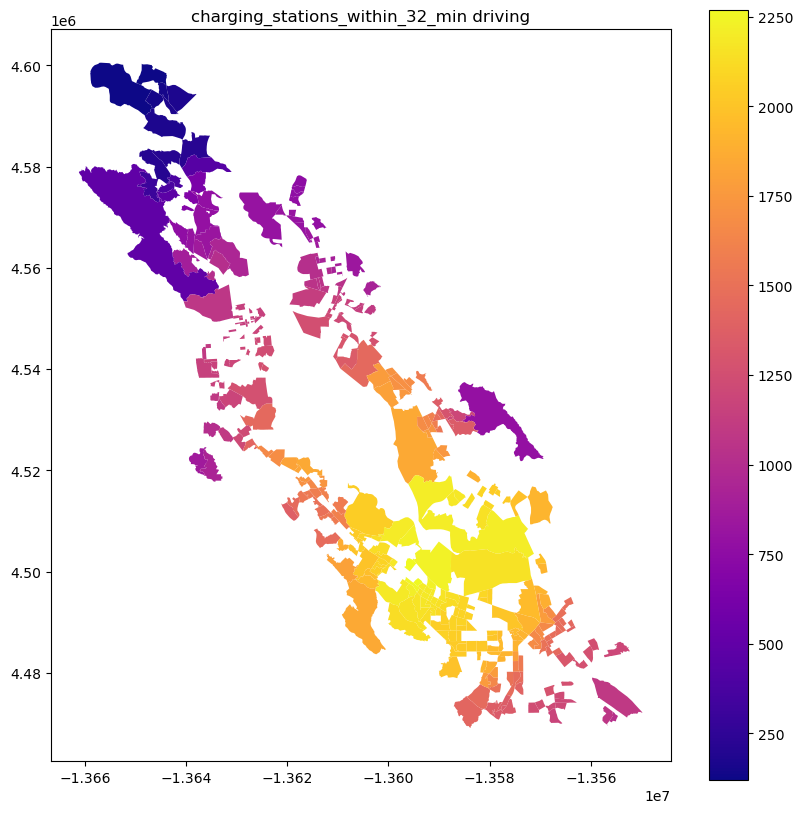

In [172]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_32_min driving'], axis=0).plot('charging_stations_within_32_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_32_min driving')
plt.savefig('charging_stations_within_32_min driving', bbox_inches='tight', dpi=600)

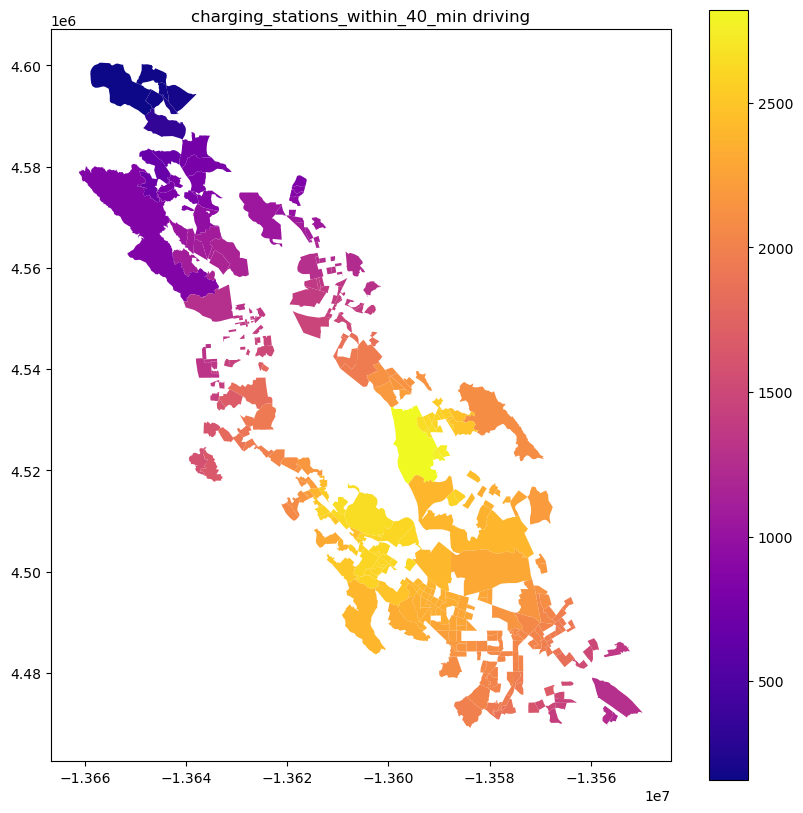

In [173]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_40_min driving'], axis=0).plot('charging_stations_within_40_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_40_min driving')
plt.savefig('charging_stations_within_40_min driving', bbox_inches='tight', dpi=600) 

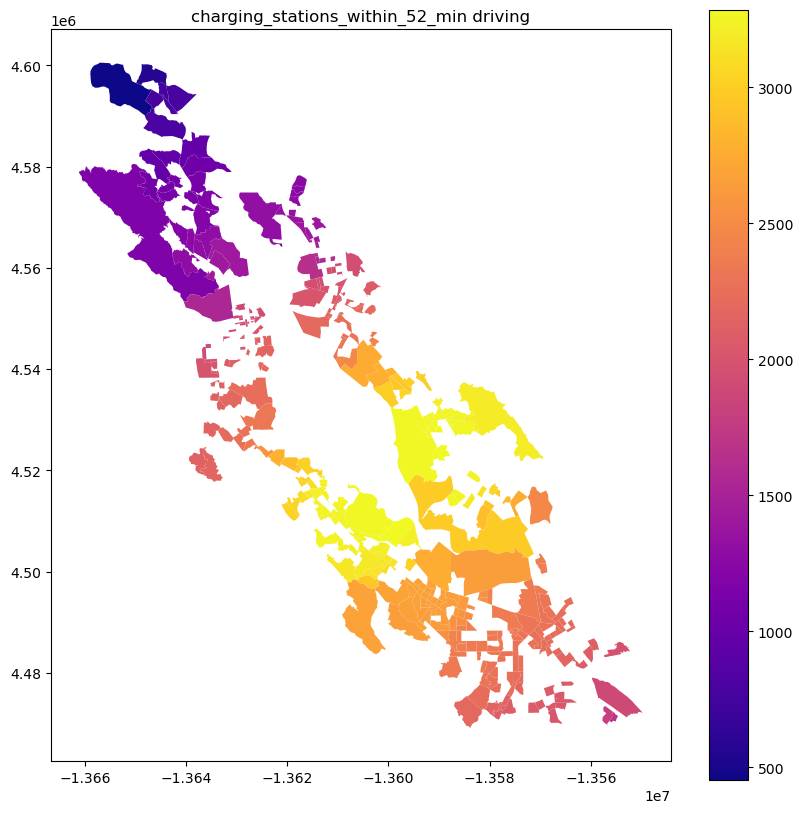

In [174]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_52_min driving'], axis=0).plot('charging_stations_within_52_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_52_min driving')
plt.savefig('charging_stations_within_52_min driving', bbox_inches='tight', dpi=600)

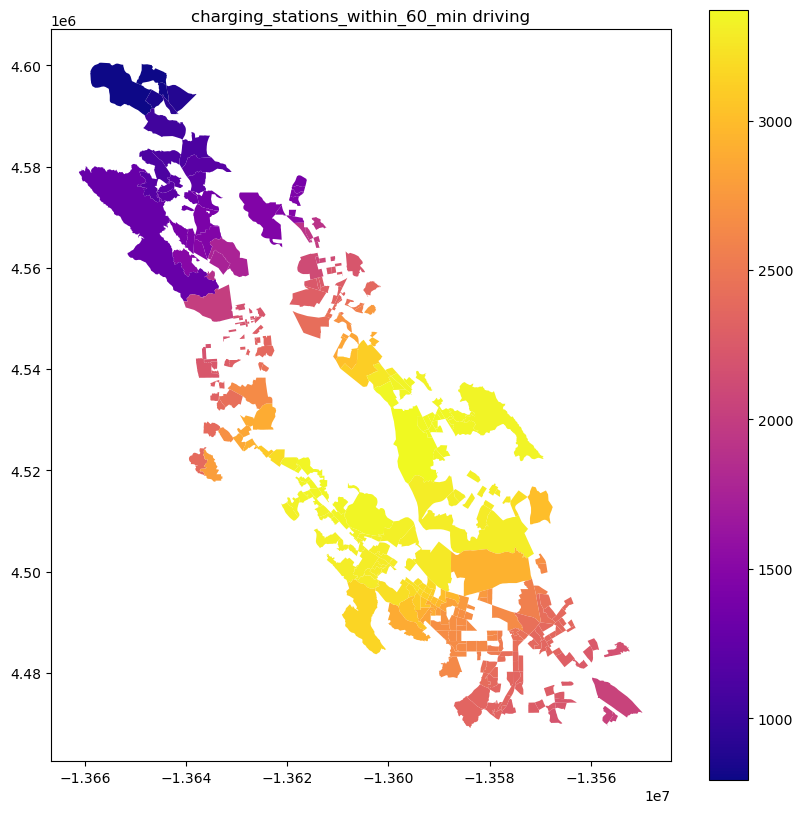

In [175]:
f, ax = plt.subplots(1,1,figsize=(10,10))
census_tracts.dropna(subset=['charging_stations_within_60_min driving'], axis=0).plot('charging_stations_within_60_min driving', ax=ax, cmap='plasma',legend=True)
# ax.set_facecolor('k')
plt.title('charging_stations_within_60_min driving')
plt.savefig('charging_stations_within_60_min driving', bbox_inches='tight', dpi=600)

In [183]:
extra_cs = census_tracts
extra_cs_per_miniute_list=[]
extra_cs_per_miniute_pct_list=[]

In [184]:
def extra_cs_per_miniute(x1,x2):
    # calculate the difference in reachable charging stations between 10 and 5 minutes  
    extra_cs['additional_stations_within_1_minutes'] = (extra_cs[f'charging_stations_within_{x2}_min driving'] - extra_cs[f'charging_stations_within_{x1}_min driving'])/(x2-x1)

    # calculate the percentage increase in reachable charging stations
    extra_cs['percentage_increase_within_1_minutes'] = (extra_cs['additional_stations_within_1_minutes'] / extra_cs[f'charging_stations_within_{x1}_min driving'])
    extra_cs_per_miniute_list.append(extra_cs['additional_stations_within_1_minutes'].mean())
    extra_cs_per_miniute_pct_list.append(extra_cs['percentage_increase_within_1_minutes'].mean())

In [192]:
extra_cs_per_miniute(12,5)
extra_cs_per_miniute(17,12)
extra_cs_per_miniute(22,17)
extra_cs_per_miniute(27,22)
extra_cs_per_miniute(32,27)
extra_cs_per_miniute(40,32)
extra_cs_per_miniute(52,40)
extra_cs_per_miniute(60,52)

import statistics
print(sum(extra_cs_per_miniute_list)/len(extra_cs_per_miniute_list))
print(sum(extra_cs_per_miniute_pct_list)/len(extra_cs_per_miniute_pct_list))


# calculate the standard deviation of the list
stdev_value = statistics.stdev(extra_cs_per_miniute_list)
print(stdev_value)
stdev_pct = statistics.stdev(extra_cs_per_miniute_pct_list)
print(stdev_pct)



46.47555628501401
0.047999049930614275
8.358407700245031
0.029345013830136976


In [214]:
describe_cs = extra_cs['charging_stations_count'].describe()
# describe_cs = extra_cs['charging_stations_count'].tolist()
print(describe_cs)

count    340.000000
mean       8.455882
std       23.887910
min        1.000000
25%        1.000000
50%        2.000000
75%        8.000000
max      322.000000
Name: charging_stations_count, dtype: float64
